In [1]:
# Mount drive (if using google colab)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


/content/drive/MyDrive/B3/Machine Learning in Medicine/Practice_2/data/training_set/404_HC.png


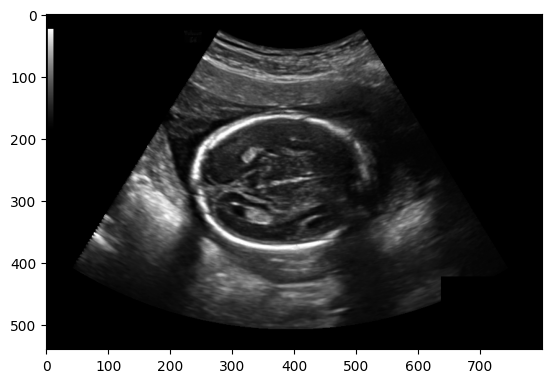

/content/drive/MyDrive/B3/Machine Learning in Medicine/Practice_2/data/training_set/404_HC_Annotation.png


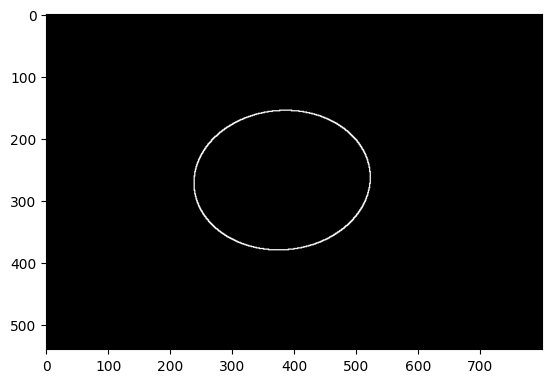

In [2]:
# Some image in training set
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt

path = "/content/drive/MyDrive/B3/Machine Learning in Medicine/Practice_2/data/training_set"

for file in os.listdir(path):
  if file.endswith("HC.png"):
    print(os.path.join(path, file))
    img = plt.imread(os.path.join(path, file),0) # [H,W]
    plt.imshow(img, cmap='gray')
    plt.show()
    break

for file in os.listdir(path):
  if file.endswith("Annotation.png"):
    print(os.path.join(path, file))
    img = plt.imread(os.path.join(path, file),0)
    plt.imshow(img, cmap='gray')
    plt.show()
    break



(800, 540)


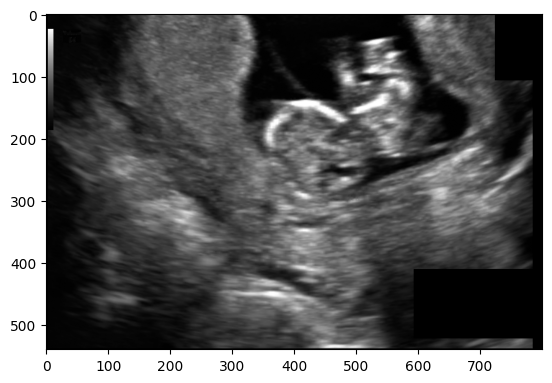

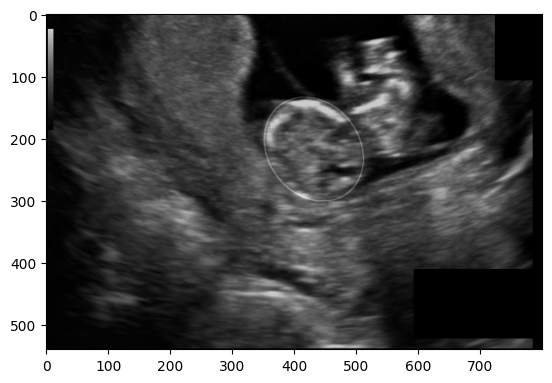

In [ ]:
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt

im_path = "/content/drive/MyDrive/B3/Machine Learning in Medicine/Practice_2/data/training_set/009_HC.png"
anno_path = "/content/drive/MyDrive/B3/Machine Learning in Medicine/Practice_2/data/training_set/009_HC_Annotation.png"

image = Image.open(im_path).convert("L")
print(image.size)
plt.imshow(image, cmap='gray')
plt.show()

img = plt.imread(im_path,0)
anno = plt.imread(anno_path,0)

plt.imshow(img, cmap='gray')
plt.imshow(anno, cmap='gray',alpha=0.2)
plt.show()

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import os
from torchvision.io import decode_image
from torchvision import transforms
from PIL import Image

class ImageDataset(Dataset):
  def __init__(self, img_path, cir_path, transform = None):
    self.img_list = []
    self.anno_dict = {}
    self.img_path = img_path

    if not transform:
      self.transform = transforms.Compose(
          [
            transforms.Grayscale(),
            transforms.Resize((256,256)),
            transforms.ToTensor(),
          ]
      )
    else: self.transform = transform

    for file in os.listdir(img_path):
      if file.endswith("HC.png"):
        self.img_list.append(file)
    with open(cir_path,"r") as f:
      lines = f.readlines()
      for line in lines:
        line = line.strip().split(",")
        if line[0] in self.img_list:
          self.anno_dict[line[0]] = torch.tensor(float(line[2]))

  def __len__(self):
    return len(self.img_list)

  def __getitem__(self, idx):
    img_name = self.img_list[idx]
    img_path = os.path.join(self.img_path, img_name)
    image = Image.open(img_path) # (W,H)
    image = self.transform(image) # (1,W,H)
    annotation = self.anno_dict[img_name]

    return image, annotation

class HeadCirPred(torch.nn.Module):
  def __init__(self):
    super(HeadCirPred, self).__init__()
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
    self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
    self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.conv4 = torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    self.dropout = torch.nn.Dropout(p=0.5)

    self.fc1 = torch.nn.Linear(in_features=256*64*64, out_features=512)
    self.fc2 = torch.nn.Linear(in_features=512, out_features=1)

  def forward(self, x):
    x = torch.relu(self.conv1(x))
    x = torch.relu(self.conv2(x))
    x = self.pool(x)

    x = torch.relu(self.conv3(x))
    x = torch.relu(self.conv4(x))
    x = self.pool(x)

    x = x.view(-1, 256*64*64)
    x = torch.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Train Loss: 6196.2608, Val Loss: 3611.5161
Epoch 2/10, Train Loss: 5779.3303, Val Loss: 3868.3356
Epoch 3/10, Train Loss: 6026.3872, Val Loss: 3810.1733
Epoch 4/10, Train Loss: 5371.6741, Val Loss: 3584.9452
Epoch 5/10, Train Loss: 4826.1106, Val Loss: 3215.1328
Epoch 6/10, Train Loss: 5035.8246, Val Loss: 3389.9536
Epoch 7/10, Train Loss: 4922.1635, Val Loss: 3428.5693
Epoch 8/10, Train Loss: 4495.4585, Val Loss: 3085.4843
Epoch 9/10, Train Loss: 4299.4432, Val Loss: 3040.0304
Epoch 10/10, Train Loss: 4205.0383, Val Loss: 4240.4055


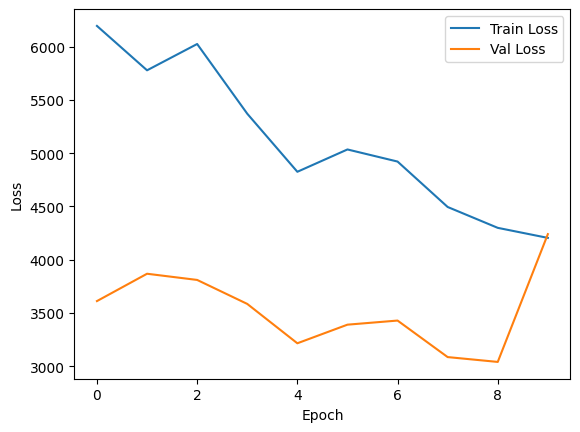

In [3]:
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data = ImageDataset("/content/drive/MyDrive/B3/Machine Learning in Medicine/Practice_2/data/training_set", "/content/drive/MyDrive/B3/Machine Learning in Medicine/Practice_2/data/training_set_pixel_size_and_HC.csv")
# test_dataloader = DataLoader(ImageDataset("/content/drive/MyDrive/B3/Machine Learning in Medicine/Practice_2/data/test_set"), batch_size=64, shuffle=False)

train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_dataset, val_dataset = random_split(data, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)

model = HeadCirPred()
model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 20
train_loss = []
val_loss_list = []

for epoch in range(epochs):
  model.train()
  running_loss = 0.0
  for image, annotation in train_dataloader:
    image, annotation = image.to(device), annotation.to(device)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, annotation)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for image, annotation in val_dataloader:
      image, annotation = image.to(device), annotation.to(device)
      output = model(image)
      loss = criterion(output, annotation)
      val_loss += loss.item()

  train_loss.append(running_loss/len(train_dataloader))
  val_loss_list.append(val_loss/len(val_dataloader))

  print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss_list[-1]:.4f}")

plt.plot(range(epochs), train_loss, label="Train Loss")
plt.plot(range(epochs), val_loss_list, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

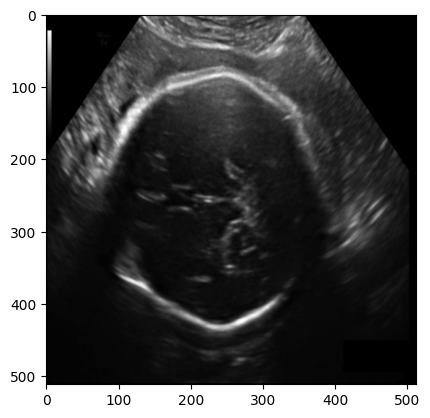

In [ ]:
img, ann = next(iter(train_dataloader))
plt.imshow(img[0].permute(1,2,0), cmap="gray")
plt.show()

In [ ]:
A = torch.rand(1,1,2,2)
A

tensor([[[[0.6633, 0.8879],
          [0.1617, 0.2928]]]])

In [ ]:
import torch
B = torch.Tensor([0.5,6])
B_expanded = B.view(1, 1, 1, 1, 2).expand(1, 1, 2, 2, 2)
C = torch.concat([A.unsqueeze(-1),B_expanded],dim=-1)
C[0][0][:,:,2]

tensor([[6., 6.],
        [6., 6.]])